In [96]:
!pip install ipywidgets


In [98]:
!pip install plotly


In [100]:
import plotly.express as px
import plotly.graph_objects as go


🏠 SMART HOME VISUAL DASHBOARD

👣 Movement Sequence: a → j → k → k → o → o → j → a → a → a → j → k → k → o → o → j → a → a → a → j ...


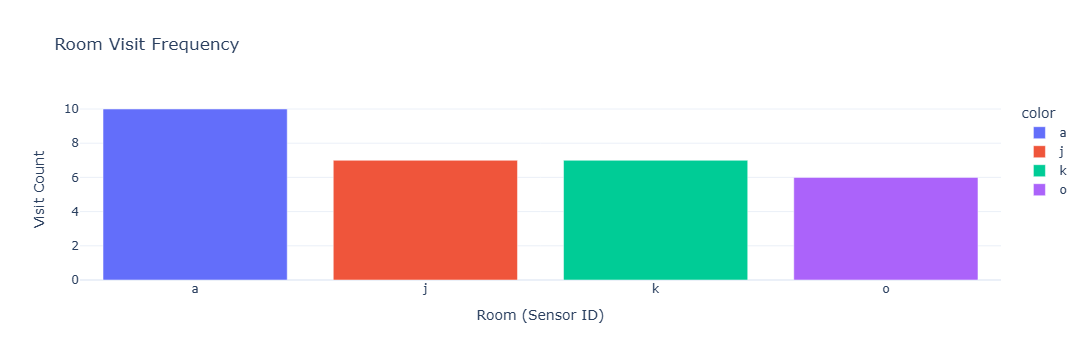

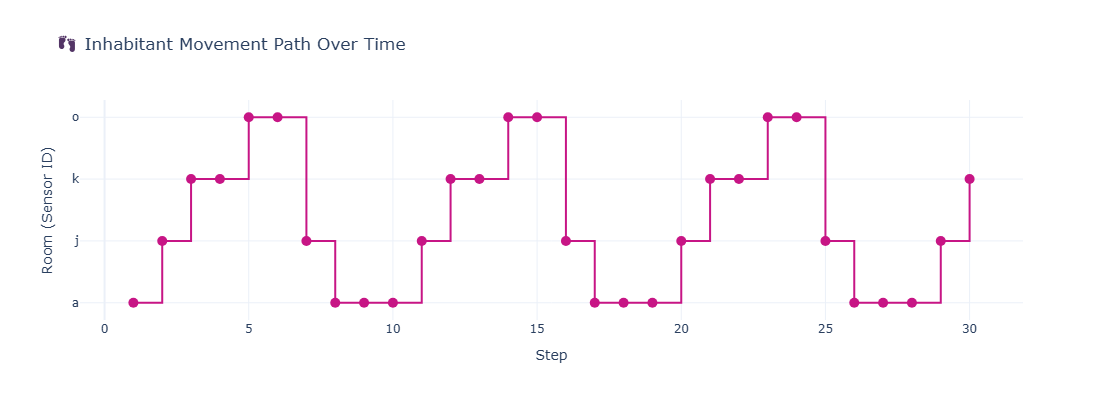

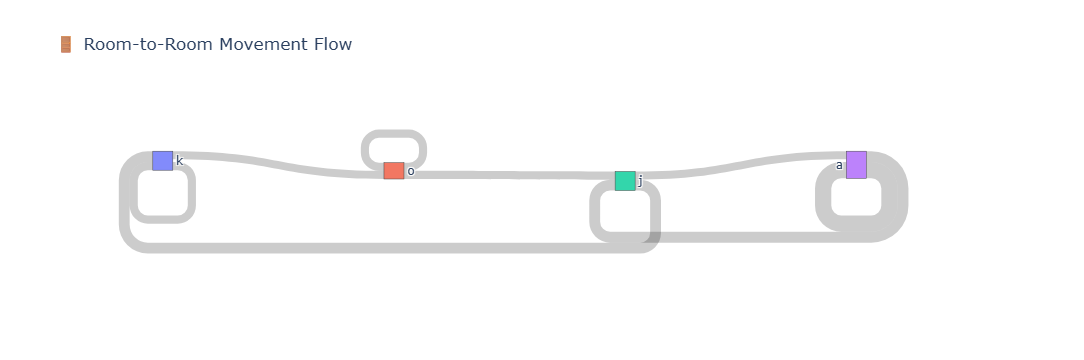

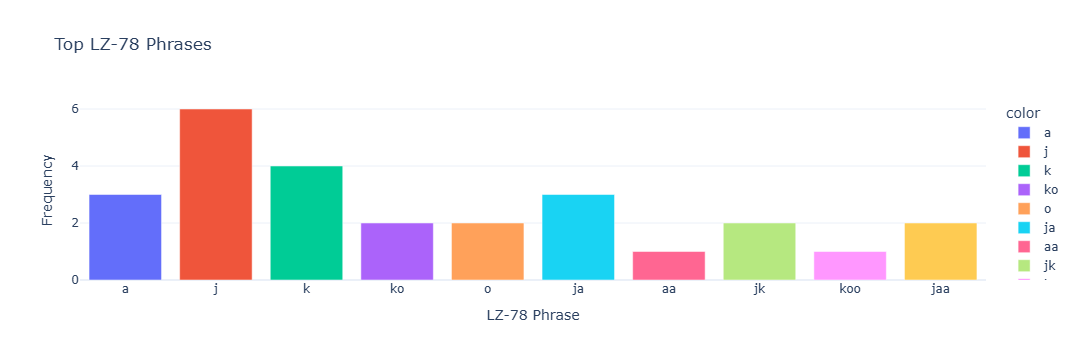

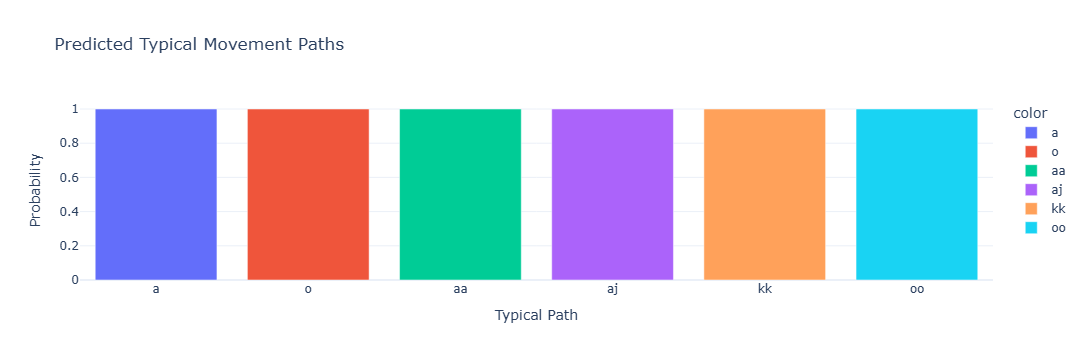

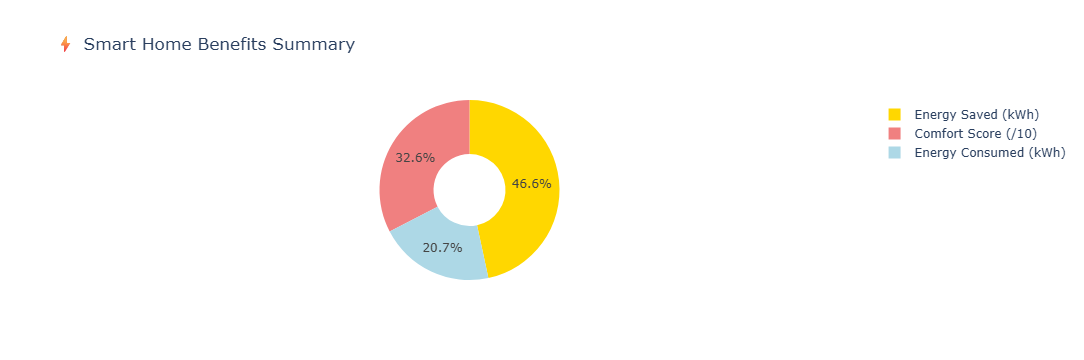

🎯 Summary
   - Total Rooms Visited: 4
   - Total LZ-78 Phrases Extracted: 14
   - Typical Paths Predicted: 6
   - ⚡ Energy Consumed: 1.20 kWh
   - 💡 Energy Saved: 2.70 kWh
   - 😌 Comfort Score: 1.89/10


In [102]:
# Imports
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter
from mobility_profile import simulate_movement
from lz_trie import LZ78Trie
from prediction import Predictor
from comfort_model import ComfortModel

# ✅ UPDATED EnergyManager class with predict_consumption method
class EnergyManager:
    def __init__(self):
        # Estimated power consumption per room (in kWh per hour)
        self.room_power = {
            'LivingRoom': 0.5,
            'Kitchen': 0.8,
            'Bedroom': 0.4,
            'Bathroom': 0.3,
            'Office': 0.6
        }

    def calculate_savings(self, predicted_paths):
        baseline = sum(self.room_power.values()) * 1.5  # Assume 1.5 hours average baseline usage
        optimized = 0
        usage_time = 1.0  # Assume 1 hour per used room

        used_rooms = set("".join(predicted_paths))  # merge all path sequences
        for room in used_rooms:
            power = self.room_power.get(room, 0.3)
            optimized += power * usage_time

        savings = baseline - optimized
        return round(savings, 2)

    def predict_consumption(self, active_paths):
        """
        Estimate total energy consumption for given active paths.
        Each room is assumed to be used for a fixed duration.
        """
        usage_time = 1.0  # Assume 1 hour usage per room
        total = 0
        used_rooms = set("".join(active_paths))

        for room in used_rooms:
            power = self.room_power.get(room, 0.3)
            total += power * usage_time

        return round(total, 2)

# Main logic
def main():
    print("🏠 SMART HOME VISUAL DASHBOARD\n")

    # Step 1: Simulate Movement
    movements = simulate_movement()
    print("👣 Movement Sequence:", " → ".join(movements[:20]), "..." if len(movements) > 20 else "")

    # 🌐 Room Visit Frequency (Bar Chart)
    room_counts = Counter(movements)
    fig1 = px.bar(x=list(room_counts.keys()), y=list(room_counts.values()),
                  labels={'x': 'Room (Sensor ID)', 'y': 'Visit Count'},
                  title='Room Visit Frequency',
                  color=list(room_counts.keys()))
    fig1.update_layout(template='plotly_white')
    fig1.show()

    # 🔁 Movement Path Timeline (Line Chart)
    steps = list(range(1, len(movements) + 1))
    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(
        x=steps,
        y=movements,
        mode='lines+markers',
        line=dict(shape='hv', color='mediumvioletred'),
        marker=dict(size=10),
        name='Movement Path'
    ))
    fig2.update_layout(
        title="👣 Inhabitant Movement Path Over Time",
        xaxis_title="Step",
        yaxis_title="Room (Sensor ID)",
        template="plotly_white",
        height=400
    )
    fig2.show()

    # 🔀 Room-to-Room Transitions (Sankey Diagram)
    transitions = [(movements[i], movements[i+1]) for i in range(len(movements)-1)]
    transition_counts = Counter(transitions)
    labels = list(set([room for pair in transition_counts for room in pair]))
    label_index = {label: i for i, label in enumerate(labels)}
    sources = [label_index[a] for (a, b) in transition_counts]
    targets = [label_index[b] for (a, b) in transition_counts]
    values  = list(transition_counts.values())

    fig3 = go.Figure(data=[go.Sankey(
        node=dict(label=labels, pad=15, thickness=20),
        link=dict(source=sources, target=targets, value=values)
    )])
    fig3.update_layout(title_text="🚪 Room-to-Room Movement Flow", font_size=12)
    fig3.show()

    # Step 2: LZ-78 Dictionary
    trie = LZ78Trie()
    for s in movements:
        trie.insert(s)

    phrase_data = list(trie.dictionary.items())[:10]
    if phrase_data:
        phrases, freqs = zip(*phrase_data)
        fig4 = px.bar(x=phrases, y=freqs,
                      labels={'x': 'LZ-78 Phrase', 'y': 'Frequency'},
                      title='Top LZ-78 Phrases',
                      color=phrases)
        fig4.update_layout(template='plotly_white')
        fig4.show()
    else:
        print("❌ No LZ-78 phrases found.")

    # Step 3: Predict Typical Paths
    predictor = Predictor(trie)
    typical_paths = predictor.get_typical_paths()

    if typical_paths:
        fig5 = px.bar(x=typical_paths[:10], y=[1]*len(typical_paths[:10]),
                      labels={'x': 'Typical Path', 'y': 'Probability'},
                      title='Predicted Typical Movement Paths',
                      color=typical_paths[:10])
        fig5.update_layout(template='plotly_white')
        fig5.show()
    else:
        print("❌ No typical paths found.")

    # Step 4: Energy & Comfort
    energy_mgr = EnergyManager()
    comfort_model = ComfortModel()

    saved_energy = energy_mgr.calculate_savings(typical_paths)
    energy_consumed = energy_mgr.predict_consumption(typical_paths)
    comfort_score = comfort_model.evaluate(temp=72, humidity=60)

    fig6 = go.Figure(data=[go.Pie(
        labels=['Energy Saved (kWh)', 'Energy Consumed (kWh)', 'Comfort Score (/10)'],
        values=[saved_energy, energy_consumed, comfort_score],
        hole=0.4,
        marker_colors=['gold', 'lightblue', 'lightcoral']
    )])
    fig6.update_layout(title="⚡ Smart Home Benefits Summary", template='plotly_white')
    fig6.show()

    # Final Summary
    print("🎯 Summary")
    print(f"   - Total Rooms Visited: {len(set(movements))}")
    print(f"   - Total LZ-78 Phrases Extracted: {len(trie.dictionary)}")
    print(f"   - Typical Paths Predicted: {len(typical_paths)}")
    print(f"   - ⚡ Energy Consumed: {energy_consumed:.2f} kWh")
    print(f"   - 💡 Energy Saved: {saved_energy:.2f} kWh")
    print(f"   - 😌 Comfort Score: {comfort_score:.2f}/10")

# Run it
main()
